In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.dates as mdates
from scipy.fft import fft, fftfreq

In [2]:
script_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'Senior Design', 'scripts'))
if script_dir not in sys.path:
    sys.path.append(script_dir)
from raw_data import create_df

### Loading in the CSV File
- make sure your file system is set up correctly
- set the ItemTest tag logging path to \sheets within this repository

In [5]:
raw_df = create_df(f"3_11_25")

No matching file found


FileNotFoundError: [Errno 2] No such file or directory: '..\\test_sheets\\3_11_25_.csv'

In [ ]:
a = 1 # choose which antenna you're reading
tag = "E280116060000209FF2351F4" # choose the tag

In [ ]:
# filtering df according to tag and antenna
clean_df = raw_df[raw_df["Antenna"] == a]
clean_df = clean_df[clean_df["EPC"] == tag]
clean_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'])



### Stats - can change these if you want

In [ ]:
min_val = clean_df['RSSI'].min()
max_val = clean_df['RSSI'].max()

min_time = clean_df['Timestamp'].min()
max_time = clean_df['Timestamp'].max()

print(f"Range of RSSI: {min_val} to {max_val}")
print(f"Data Time Range: {max_time - min_time}")

avg_val = clean_df["RSSI"].mean()
print(f"Average RSSI: {avg_val}")

std_dev = clean_df["RSSI"].std()
median_val = clean_df["RSSI"].median()
variance_val = clean_df["RSSI"].var()
percentiles = clean_df["RSSI"].quantile([0.25, 0.5, 0.75])
skewness = clean_df["RSSI"].skew()
kurtosis = clean_df["RSSI"].kurtosis()
peak_to_peak = max_val - min_val

print(f"Standard Deviation: {std_dev}")
print(f"Median RSSI: {median_val}")
print(f"Variance: {variance_val}")
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")
print(f"Skewness: {skewness}") # no idea
print(f"Kurtosis: {kurtosis}") # no idea what this is
print(f"Peak-to-Peak Amplitude: {peak_to_peak}")

Range of RSSI: -71.0 to -55.0
Data Time Range: 0 days 00:01:03.682202
Average RSSI: -63.23157894736842
Standard Deviation: 2.6445661617538456
Median RSSI: -64.0
Variance: 6.993730183893468
25th Percentile: -65.0
50th Percentile (Median): -64.0
75th Percentile: -61.5
Skewness: 0.25220546585848413
Kurtosis: -0.5809087049880652
Peak-to-Peak Amplitude: 16.0


### Perform FFT to find frequencies in the signal, not sure if this is even useful

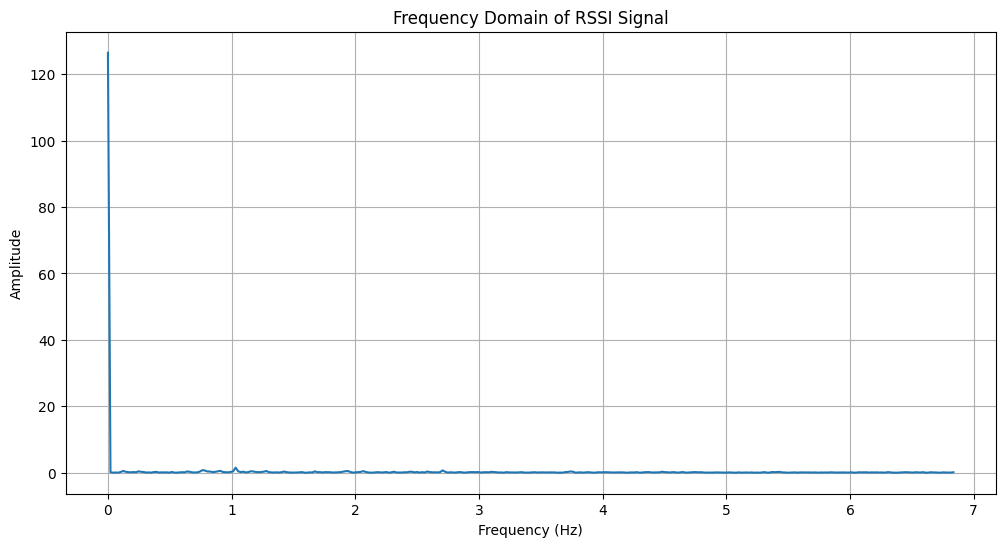

Dominant Frequency: 0.0 Hz


In [6]:
clean_df['Time_sec'] = (clean_df['Timestamp'] - clean_df['Timestamp'].min()).dt.total_seconds()

# Perform FFT
N = len(clean_df['RSSI'])
T = clean_df['Time_sec'].iloc[1] - clean_df['Time_sec'].iloc[0]  # Sample spacing
yf = fft(clean_df['RSSI'])
xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Frequency Domain of RSSI Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

dominant_freq = xf[np.argmax(2.0/N * np.abs(yf[:N//2]))]
print(f"Dominant Frequency: {dominant_freq} Hz")

### Plotting the Raw Data from the Reader
- This is the raw RSSI values that haven't been converted to distances
- The graph also displays some statistics as well
- If you want to modify/clean it, probably create a new dataframe

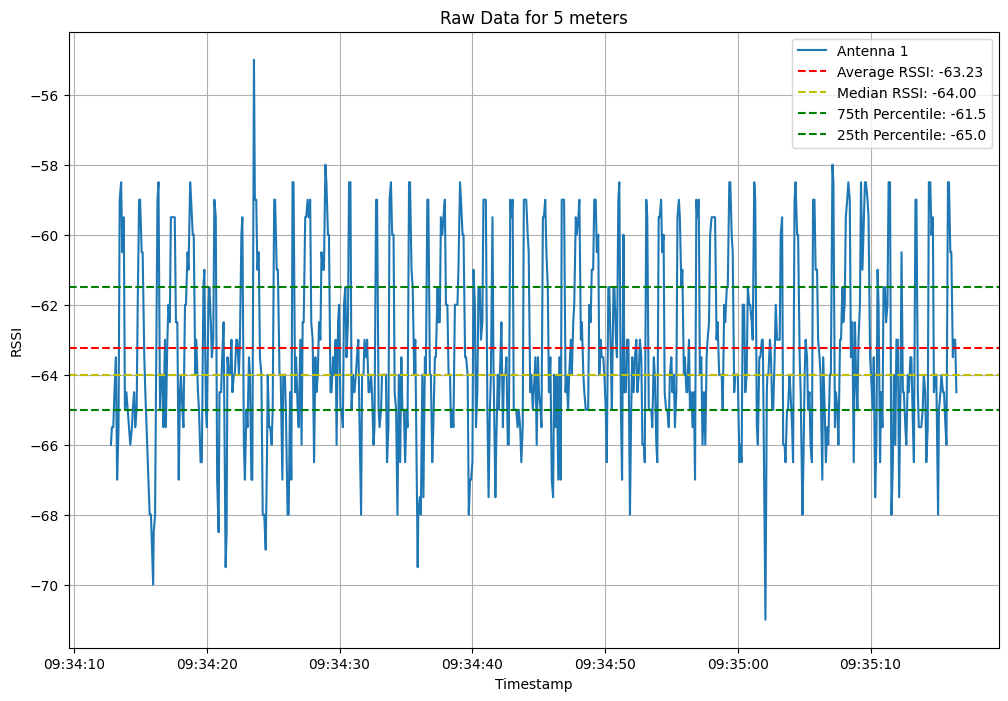

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(clean_df['Timestamp'], clean_df['RSSI'], label=f'Antenna {a}')
plt.axhline(y=avg_val, color='r', linestyle='--', label=f'Average RSSI: {avg_val:.2f}')
plt.axhline(y=median_val, color='y', linestyle='--', label=f'Median RSSI: {median_val:.2f}')
plt.axhline(y=percentiles[0.75], color='g', linestyle='--', label=f"75th Percentile: {percentiles[0.75]}")
plt.axhline(y=percentiles[0.25], color='g', linestyle='--', label=f"25th Percentile: {percentiles[0.25]}")
plt.xlabel('Timestamp')
plt.ylabel('RSSI')
plt.title(f'Raw Antenna Values')
plt.legend()
plt.grid(True)
plt.show()

### Performing a Moving Average Filter on the Data
- Need to determine a good window size, modify the `filter_window` variable to see different graphs
- From what I've seen, a larger window is better
- We may need to have another filtering step before this so that the window points don't get skewed by outliers
- Could also experiment with a median filter or some other types of filters, idk

In [14]:
# moving average
filter_window = 10
clean_df["Norm_RSSI"] = clean_df["RSSI"].rolling(window=filter_window).mean()

In [9]:
min_val = clean_df['Norm_RSSI'].min()
max_val = clean_df['Norm_RSSI'].max()

min_time = clean_df['Timestamp'].min()
max_time = clean_df['Timestamp'].max()

print(f"Range of RSSI: {min_val} to {max_val}")
print(f"Data Time Range: {max_time - min_time}")

avg_val = clean_df["Norm_RSSI"].mean()
print(f"Average RSSI: {avg_val}")

std_dev = clean_df["Norm_RSSI"].std()
median_val = clean_df["Norm_RSSI"].median()
variance_val = clean_df["Norm_RSSI"].var()
percentiles = clean_df["Norm_RSSI"].quantile([0.25, 0.5, 0.75])
skewness = clean_df["Norm_RSSI"].skew()
kurtosis = clean_df["Norm_RSSI"].kurtosis()
peak_to_peak = max_val - min_val

print(f"Standard Deviation: {std_dev}")
print(f"Median RSSI: {median_val}")
print(f"Variance: {variance_val}")
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")
print(f"Peak-to-Peak Amplitude: {peak_to_peak}")

Range of RSSI: -64.06 to -62.34
Data Time Range: 0 days 00:01:03.682202
Average RSSI: -63.20946428571428
Standard Deviation: 0.39064699972892725
Median RSSI: -63.23
Variance: 0.1526050783972125
25th Percentile: -63.52
50th Percentile (Median): -63.23
75th Percentile: -62.88
Skewness: 0.13841082345860012
Kurtosis: -0.8928746453641696
Peak-to-Peak Amplitude: 1.7199999999999989


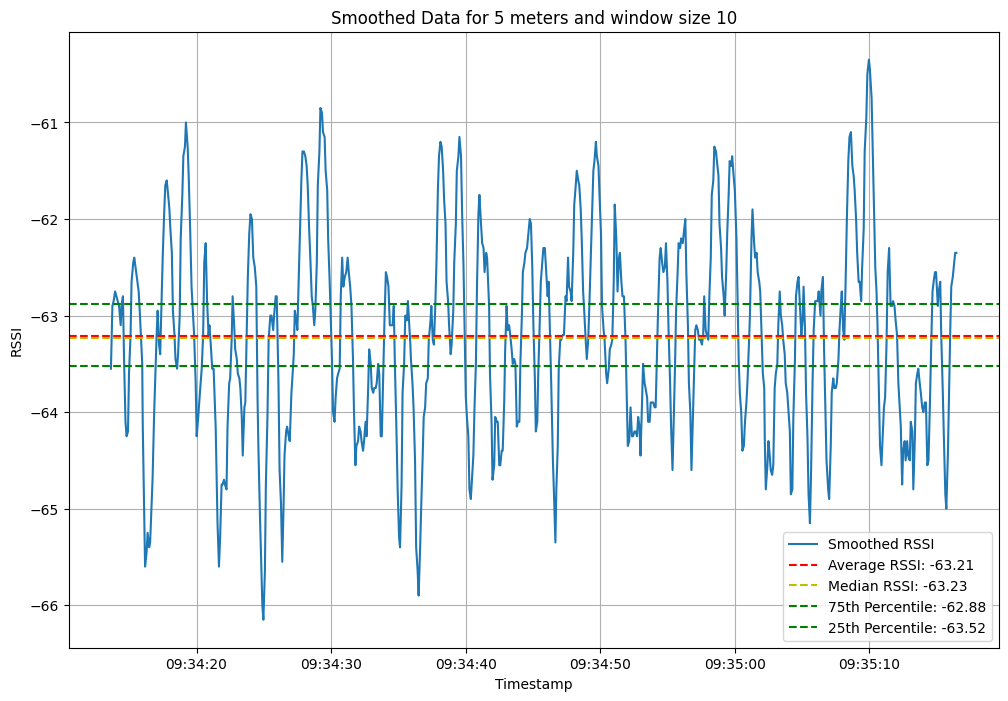

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(clean_df['Timestamp'], clean_df['Norm_RSSI'], label=f'Smoothed RSSI')
plt.axhline(y=avg_val, color='r', linestyle='--', label=f'Average RSSI: {avg_val:.2f}')
plt.axhline(y=median_val, color='y', linestyle='--', label=f'Median RSSI: {median_val:.2f}')
plt.axhline(y=percentiles[0.75], color='g', linestyle='--', label=f"75th Percentile: {percentiles[0.75]}")
plt.axhline(y=percentiles[0.25], color='g', linestyle='--', label=f"25th Percentile: {percentiles[0.25]}")
plt.xlabel('Timestamp')
plt.ylabel('RSSI')
plt.title(f'Smoothed Data with Window Size {filter_window}')
plt.legend()
plt.grid(True)
plt.show()